Regla delta generalizada y algoritmos con supermemoria
===

* *30 min* | Ultima modificación: Junio 22, 2019

## Descripción del problema

En el algoritmo de gradiente descendente, el proceso de optimización usa la siguiente ecuación recursiva:

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{f}(\mathbf{w}_{k-1})$$

Como caso de aplicación se desea ajustar el modelo de regresión lineal 

$$y_i = w_0 + w_1 * x_i$$

al siguiente conjunto de datos:

In [1]:
x = [0.1087,  0.2698,  0.3765,  0.2146,  0.9155,  
     0.0246,  0.0221,  0.8632,  0.6460,  0.2092,  
     0.8567,  0.1591,  0.9647,  0.6231,  0.7460,  
     0.3654,  0.3065,  0.6886,  0.4966,  0.2008,  
     0.2618,  0.7607,  0.1563,  0.4424,  0.7731]

d = [0.9519,  1.1237,  1.2360,  1.0526,  2.0743,
     0.7906,  0.7603,  2.0533,  1.6887,  1.0563,
     2.0991,  0.8953,  2.1917,  1.6266,  1.8508,
     1.2828,  1.2283,  1.8722,  1.4657,  1.0418,
     1.1097,  1.7826,  0.9711,  1.4267,  1.8248]

Para ello, se usa como función de pérdida la sumatoria del error cuadrático (SSE) definda como:

$$\text{SSE}(w_0, w_1) = \sum_i (d_i - w_0 - w_1 x_i)^2 $$

In [2]:
#
# Sumatoria del error cuadrático o pérdida cuadrática
#
def SSE(w0, w1):
    return (sum( [(v - w0 - w1*u)**2  for u, v in zip(x, d)] ))

Como ya se explicó, la función SSE() es una cuadrática con forma de tazón y un único punto de mínima que corresponde al valor óptimo de los parámetros $w_0$ y $w_1$. La gráfica de la cuadrática es presentada a continuación.

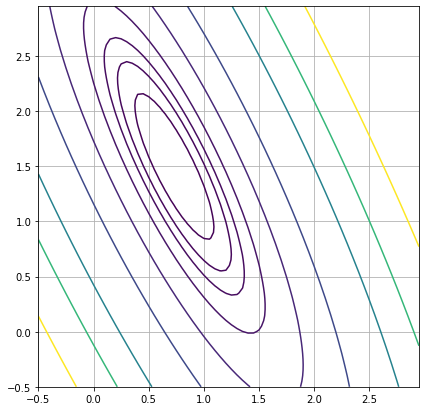

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_contour():
    #
    W0 = np.arange(-0.5, 3.0, 0.05)
    W1 = np.arange(-0.5, 3.0, 0.05)
    W0, W1 = np.meshgrid(W0, W1)
    F = SSE(W0, W1)
    #
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_aspect('equal', 'box')
    ax.contour(W0, W1, F, levels=[0, 1, 2, 3, 5, 10, 20, 40, 60, 90])
    ax.grid()
    
plot_contour()

Tal como ya se habia explicado, la técnica del gradiente descendente se basa en un proceso iterativo que usa la siguiente ecuación para refinar la aproximación al valor óptimo de los parámetros:

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

con:

$$\frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1}) = 
\left[
  \begin{array}{c}
  -2 \sum_i  e_{i,k-1}
  \\
  -2 \sum_i  e_{i,k-1} x_i
  \end{array}
\right]
$$

Estos cómputos son implementados a continuación.

In [4]:
#
# Gradiente de la función de error (SSE)
#
def gSSE(w0, w1):
    e = [(v - w0 - w1*u)  for u, v in zip(x, d)]
    gw0 = -2 * sum(e)
    gw1 = -2 * sum([q*v for q, v in zip(e,x)])    
    return (gw0, gw1)

In [5]:
def mejora(w0, w1, mu):
    ## computa el gradiente para los parámetros actuales
    gw0, gw1 = gSSE(w0, w1)
    
    ## realiza la corrección de los parámetros
    w0 = w0 - mu * gw0
    w1 = w1 - mu * gw1
    
    ## retorna los parámetros corregidos
    return (w0, w1)

El proceso de optimización se realiza de un punto inicial arbitrario. A continuación se presenta el valor encontrado y la traza de puntos que recorre el algoritmo hasta llegar al óptimo.


Valores encontrados

  w0 = 0.675531
  w1 = 1.643269



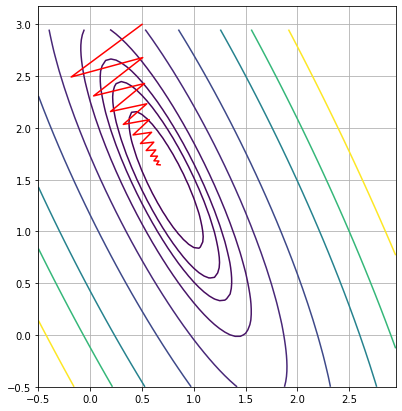

In [6]:
# Punto de inicio
w0 = 0.5
w1 = 3.0

history_w0 = [w0]
history_w1 = [w1]
history_f  = [SSE(w0, w1)]

for epoch in range(20):
    w0, w1 = mejora(w0, w1, 0.03)
    history_w0.append(w0)
    history_w1.append(w1)
    history_f.append(SSE(w0, w1))

print('\nValores encontrados\n\n  w0 = {:f}\n  w1 = {:f}\n'.format(w0, w1))    

plot_contour()
plt.plot(history_w0, history_w1, color='red');

Note que el algoritmo realiza una caminata en zigzag (va y se devuelve) intentando llegar al óptimo. Este comportamiento es indeseable y se desea evitar el zigzag ya que se desperdician iteraciones para llegar al óptimo.

## Solución

Para evitar el zigzag, se desea usar la dirección del gradiente actual ponderada por la dirección previa. Esta metodología se conoce como regla delta (en la jerga de redes neuronales artificiales) o gradiente con memoria (en investigación de operaciones). 

Específicamente, el proceso de optimización se basa en la siguiente ecuación recursiva (ya estudiada):

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

la cual que puede ser reescrita como:

$$\mathbf{w}_k = \mathbf{w}_{k-1} + \Delta \mathbf{w}_{k-1}$$

con:

$$\Delta \mathbf{w}_{k-1} = - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

La dirección tomada en la iteración anterior será $\Delta \mathbf{w}_{k-2}$. Ahora, solo es necesario agregar este término a la ecuación anterior, ponderado por un parámetro $\beta$ conocido comúnmente como *momentum*:

$$\Delta \mathbf{w}_{k-1} = - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1}) + \beta \Delta \mathbf{w}_{k-2}$$

La implementación es la siguiente:

In [7]:
def mejora(w0, w1, mu, beta):
    
    # Corrección en la iteración anterior.
    global previous_delta_w0
    global previous_delta_w1
    
    # Computó del gradiente para los parámetros actuales
    gw0, gw1 = gSSE(w0, w1)
    
    # Corrección de los parámetros
    delta_w0 = - mu * gw0 + beta * previous_delta_w0
    delta_w1 = - mu * gw1 + beta * previous_delta_w1
    
    # Almacenamiento de la corrección para la siguiente iteración
    previous_delta_w0 = delta_w0
    previous_delta_w1 = delta_w1
    
    w0 = w0 + delta_w0
    w1 = w1 + delta_w1
    
    # retorna los parámetros corregidos
    return (w0, w1)

El proceso de iterativo de optimización es el siguiente:


Valores encontrados

  w0 = 0.717213
  w1 = 1.535152



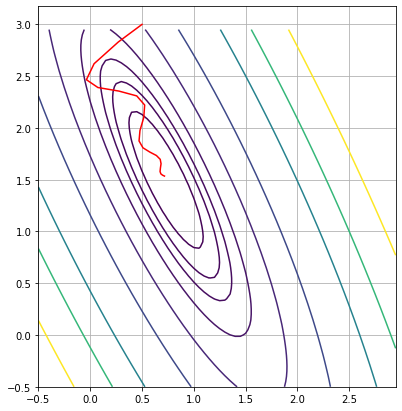

In [8]:
# Punto de inicio
w0 = 0.5
w1 = 3.0

history_w0 = [w0]
history_w1 = [w1]
history_f  = [SSE(w0, w1)]

previous_delta_w0 = 0
previous_delta_w1 = 0

for epoch in range(20):
    w0, w1 = mejora(w0, w1, 0.01, 0.7)
    history_w0.append(w0)
    history_w1.append(w1)
    history_f.append(SSE(w0, w1))

print('\nValores encontrados\n\n  w0 = {:f}\n  w1 = {:f}\n'.format(w0, w1))    

plot_contour()
plt.plot(history_w0, history_w1, color='red');

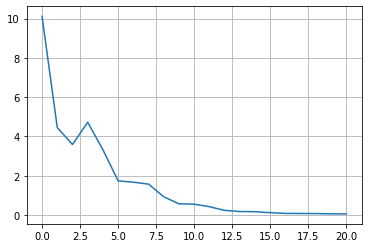

In [9]:
plt.plot(history_f, '-'); plt.grid()

**Ejercicio.---** Cuál es la mejor combinación de parámetros $\mu$ y $\beta$ para este problema?